In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import string
import os
import pickle

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import HashingVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation, Concatenate
from keras.layers import Embedding, LSTM, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import load_model
from keras.utils import plot_model

import tensorflow as tf

from transformers import BertTokenizer

/home/david/.local/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
!unzip -q "/content/pan21-author-profiling-training-2021-03-14.zip"
!mkdir "/content/results/"

In [2]:
#enDirectory = '/content/pan21-author-profiling-training-2021-03-14/en'
#esDirectory = '/content/pan21-author-profiling-training-2021-03-14/es'

esDirectory = 'dataset-pan21-author-profiling-training-2021-03-14/es'
esTestDirectory = 'pan21-author-profiling-test-without-gold/es'

enDirectory = 'dataset-pan21-author-profiling-training-2021-03-14/en'
enTestDirectory = 'pan21-author-profiling-test-without-gold/en'

In [ ]:
# 40,000 per language
# 200 authors per language
# 200 tweets per author
# balanced dataset 50/50 of each class

### Steps:

Funciones auxiliares:
- Recoger todos los tweets
- Limpiarlos, users un token, hastag un token, url un token, quitar stopwords y punctuation y tokenizar con TweetTokenizer
- Hacer un 80:20 split manteniendo autores
- Preentrenar word embeddings, luego no son tan importantes preentrenarlos
- Convertir sequencias a ints para leer por la red + OOV y PAD
- Hacer un preproceso extra para bert con BertTokenizer -> secuencias de ints y mask
- Funcion para juntar predictions y hacer author profiling (Mejorar la revisión del f1 de los modelos)
- Funcion para sacar a xml los resultados de test

Se decide explorar la longitud de los tweets para decidir una longitud máxima del vector, se exploran individualmente y por 20 tweets juntos -> 15 y 250 en longitud respectivamente. (Se pueden enseñar las tablas si eso). Entonces lo que se mete a los modelos puede ser:
- Es tweet individual
- En tweet individual
- Es 20 tweets juntos
- En 20 tweets juntos

### Functions

In [3]:
def create_dataframe(path):
    data = []

    # Load tweets
    for filename in os.listdir(path):
        if(filename == "truth.txt"):
            continue
        tree = ET.parse(path + '/' + filename)
        root = tree.getroot()

        author_id = filename.split('.')[0]
        lang = root.attrib['lang']
        t_class = int(root.attrib['class'])

        for document in root.iter('document'):        
            info = [author_id, lang, document.text, t_class]
            data.append(info)
    
    # Create DataFrame with all data
    col_names = ['author_id', 'lang', 'tweet', 'type']
    return pd.DataFrame(data, columns=col_names)

def create_dataframe_test(path):
    data = []

    # Load tweets
    for filename in os.listdir(path):
        tree = ET.parse(path + '/' + filename)
        root = tree.getroot()

        author_id = filename.split('.')[0]
        lang = root.attrib['lang']

        for document in root.iter('document'):        
            info = [author_id, lang, document.text]
            data.append(info)
    
    # Create DataFrame with all data
    col_names = ['author_id', 'lang', 'tweet']
    return pd.DataFrame(data, columns=col_names)

In [22]:
def join_tweets(df, n_tweets):
    if len(df) % n_tweets != 0:
        print("Select a divisible number of {}".format(len(df)))
        return None
    
    data = []
    for i in range(0, len(df), n_tweets):
        author_id = df['author_id'][i]
        lang = df['lang'][i]
        t_class = df['type'][i]
        tweet_clean = df['tweet_clean'][i]
        
        j = i + n_tweets
        tweet_clean = " ".join(df['tweet_clean'][i:j])

        info = [author_id, lang, tweet_clean, t_class]
        data.append(info)    
    
    # Create DataFrame with all data
    col_names = ['author_id', 'lang', 'tweet_clean', 'type']
    return pd.DataFrame(data, columns=col_names)

def join_tweets_test(df, n_tweets):
    if len(df) % n_tweets != 0:
        print("Select a divisible number of {}".format(len(df)))
        return None
    
    data = []
    for i in range(0, len(df), n_tweets):
        author_id = df['author_id'][i]
        lang = df['lang'][i]
        #t_class = df['type'][i]
        tweet_clean = df['tweet_clean'][i]
        
        j = i + n_tweets
        tweet_clean = " ".join(df_es['tweet_clean'][i:j])

        info = [author_id, lang, tweet_clean]
        data.append(info)    
    
    # Create DataFrame with all data
    col_names = ['author_id', 'lang', 'tweet_clean']
    return pd.DataFrame(data, columns=col_names)

In [5]:
reUser = re.compile(r'@+\w+')
reHashtag = re.compile(r'#+\w+')
reWeb = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})')
tokenizer = TweetTokenizer(strip_handles=False, reduce_len=True, preserve_case=False)


def clean_text_es(text):
    aux = []
    
    # Remove stopwords
    for word in text.split():
        if word not in stopwords.words("spanish"):
            aux.append(word)
    #text = " ".join(aux)
    
    # Normalize user tags
    for item in re.finditer(reUser, text):
        text = reUser.sub('#user', text)
    
    # Normalize hastags
    for item in re.finditer(reHashtag, text):
        text = reHashtag.sub('#hastag', text)
    
    # Normalize urls
    for item in re.finditer(reWeb, text):
        text = reWeb.sub('#web', text)

    # Remove punctuation except #
    punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = list(tokenizer.tokenize(text))
    text = " ".join(text)
    return text

def clean_text_en(text):
    aux = []
    
    # Remove stopwords
    for word in text.split():
        if word not in stopwords.words("english"):
            aux.append(word)
    #text = " ".join(aux)
    
    # Normalize user tags
    for item in re.finditer(reUser, text):
        text = reUser.sub('#user', text)
    
    # Normalize hastags
    for item in re.finditer(reHashtag, text):
        text = reHashtag.sub('#hastag', text)
    
    # Normalize urls
    for item in re.finditer(reWeb, text):
        text = reWeb.sub('#web', text)

    # Remove punctuation except #
    punctuation = '!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = list(tokenizer.tokenize(text))
    text = " ".join(text)
    return text

In [6]:
def get_data_from_df(dataframe, split=0.2):
    # 20 authors hate + 20 authors not in test 
    # = 40 authors = 8,000 tweets                   -> 4000 each
    # =     ...    = 8,000 tweets / 20 = 400 tweets ->  200 each
    
    n_tweets = int(len(dataframe) * split / 2)

    x_train0 = df_es.loc[(df_es.type == 0), 'tweet_clean'][n_tweets:].values
    x_train1 = df_es.loc[(df_es.type == 1), 'tweet_clean'][n_tweets:].values

    y_train0 = df_es.loc[(df_es.type == 0), 'type'][n_tweets:].values
    y_train1 = df_es.loc[(df_es.type == 1), 'type'][n_tweets:].values

    x_valid0 = df_es.loc[(df_es.type == 0), 'tweet_clean'][:n_tweets].values
    x_valid1 = df_es.loc[(df_es.type == 1), 'tweet_clean'][:n_tweets].values

    y_valid0 = df_es.loc[(df_es.type == 0), 'type'][:n_tweets].values
    y_valid1 = df_es.loc[(df_es.type == 1), 'type'][:n_tweets].values

    # HAY QUE HACER SHUFFLE AL TRAINING SET
    x_train = np.concatenate((x_train0, x_train1), axis=None)
    y_train = np.concatenate((y_train0, y_train1), axis=None)

    x_valid = np.concatenate((x_valid0, x_valid1), axis=None)
    y_valid = np.concatenate((y_valid0, y_valid1), axis=None)

    return x_train, y_train, x_valid, y_valid

In [9]:
def create_embedding_matrix(corpus, word_embedding_size, max_words=10000, oov_tok='<OOV>'):
    '''
    Parameters:
    size - size of dense vector to represent each token/word
    window - max distance between target and neighbour word
    min_count - min frequency of count of words. Ignore below threshold
    workers - # of threads to run

    sample - to downsample frequent words
    sg - if skip-gram is used (=1) else CBOW
    window - # of words looked before and after the analyzed one
    '''
    
    word_sequence = [] # w2v necesita listas de tokens
    for text in corpus:
        word_sequence.append(text.split())
    
    # Train w2v model
    w2v = Word2Vec(word_sequence,
               sg=0,
               vector_size=word_embedding_size,
               window=5,
               min_count=1,
               workers=4)

    # Needs to recieve string, hace split=(' ')
    keras_tokenizer = Tokenizer(num_words=max_words,
                                filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # all minus #
                                lower=True,
                                split=' ',
                                oov_token=oov_tok)
    # Transform text into integers
    keras_tokenizer.fit_on_texts(corpus)
    
    # Prepare embedding matrix
    embedding_matrix = np.zeros((max_words, word_embedding_size))

    for word, i in keras_tokenizer.word_index.items():
        if i >= max_words:
            break
        if word in w2v.wv.key_to_index:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = w2v.wv[word]

    return embedding_matrix

In [8]:
def to_int_seq(x_train, x_valid, x_test, max_length, max_words=10000, oov_tok='<OOV>', trunc_type='post', pad_type='post'):
    
    # Needs to recieve string, hace split=(' ')
    keras_tokenizer = Tokenizer(num_words=max_words,
                                filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # all minus #
                                lower=True,
                                split=' ',
                                oov_token=oov_tok)
    # Transform text into integers
    corpus = np.concatenate((x_train, x_valid), axis=None)
    keras_tokenizer.fit_on_texts(corpus)

    train_sequences = keras_tokenizer.texts_to_sequences(x_train)
    train_padded = pad_sequences(train_sequences,
                                 maxlen=max_length,
                                 padding=pad_type,
                                 truncating=trunc_type)

    valid_sequences = keras_tokenizer.texts_to_sequences(x_valid)
    valid_padded = pad_sequences(valid_sequences,
                                 maxlen=max_length,
                                 padding=pad_type,
                                 truncating=trunc_type)

    test_sequences = keras_tokenizer.texts_to_sequences(x_test)
    test_padded = pad_sequences(test_sequences,
                                maxlen=max_length,
                                padding=pad_type,
                                truncating=trunc_type)
    
    return train_padded, valid_padded, test_padded

In [33]:
def prepare_data_bert(sentences, max_length):
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    input_ids=[]
    attention_masks=[]

    # Cambiar para que no sea uno a uno
    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True)
        
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    return input_ids, attention_masks

In [ ]:
######### AUTHOR PROFILING FUNCTION FOR JOINING PREDICTIONS #########

# de 20 0s y 20 1s
author_profile = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

# Example predictions
predictions = np.random.rand(len(y_test))

def author_profiling_report(author_profile, author_predictions):
    # Check author profiling -> 8,000 predictions
    # Split into 40 authors -> 200 tweets per author
    author_predictions = np.average(np.array_split(predictions, 40), axis=1)
    author_predictions = np.array([1 if ap >= 0.5 else 0 for ap in author_predictions])

    print(classification_report(author_profile, author_predictions, labels=[0, 1], target_names=['not hate','hate']))

print(predictions)
author_profiling_report(author_profile, predictions)

In [ ]:
# txt output
# <author id="author-id" lang="en|es" type="0|1"/>
def format_output(author_predictions):
    root = ET.Element("author")
    root.set("id", "123")
    root.set("lang", "es")
    root.set("type", "0")

    tree = ET.ElementTree(root)
    xml_str = ET.tostring(root).decode('utf8')

    save_path_file = "person.xml"

    with open(save_path_file, "w") as f:
        f.write(xml_str) 

### Data Exploration

#### Single Tweets

In [15]:
len(df_es), len(df_en)

(40000, 40000)

In [16]:
df_es.head()

,author_id,lang,tweet,type,tweet_clean
0,f558a21dd8e02f2f7d4e5d5c3ea24195,es,muero de amor con milo 🥰,0,muero de amor con milo 🥰
1,f558a21dd8e02f2f7d4e5d5c3ea24195,es,"vieron cuando les da paja hablar con alguien, ...",0,vieron cuando les da paja hablar con alguien b...
2,f558a21dd8e02f2f7d4e5d5c3ea24195,es,mi abuela me manda audios de TRES MINUTOS Y ME...,0,mi abuela me manda audios de tres minutos y me...
3,f558a21dd8e02f2f7d4e5d5c3ea24195,es,lo amo fuerte #URL#,0,lo amo fuerte hastag
4,f558a21dd8e02f2f7d4e5d5c3ea24195,es,mi especialidad son las tartas no se habla mas,0,mi especialidad son las tartas no se habla mas


In [17]:
df_es['tweetLength'] = df_es['tweet_clean'].str.split().map(len)
print("---Es---")
print(df_es['tweetLength'].describe())

---Es---
count    40000.000000
mean        13.300525
std          5.568387
min          3.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         81.000000
Name: tweetLength, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

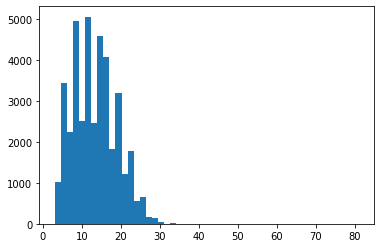

In [18]:
plt.hist(df_es['tweetLength'], 50)
plt.show

In [19]:
df_en.head()

,author_id,lang,tweet,type,tweet_clean
0,99cb2cd23f7cf613d394502d17dedad0,en,First Catering 😎 #URL#,0,first catering 😎 hastag
1,99cb2cd23f7cf613d394502d17dedad0,en,RT #USER#: vibes with someone come naturally. ...,0,rt hastag vibes with someone come naturally do...
2,99cb2cd23f7cf613d394502d17dedad0,en,RT #USER#: never force nobody to appreciate you.,0,rt hastag never force nobody to appreciate you
3,99cb2cd23f7cf613d394502d17dedad0,en,RT #USER#: That camera pan to the horny niggas...,0,rt hastag that camera pan to the horny niggas ...
4,99cb2cd23f7cf613d394502d17dedad0,en,RT #USER#: Buying a $50 dollar bottle of liquo...,0,rt hastag buying a 50 dollar bottle of liquor ...


In [20]:
df_en['tweetLength'] = df_en['tweet_clean'].str.split().map(len)
print("---En---")
print(df_en['tweetLength'].describe())

---En---
count    40000.000000
mean        12.924000
std          5.706929
min          2.000000
25%          8.000000
50%         12.000000
75%         17.000000
max         61.000000
Name: tweetLength, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

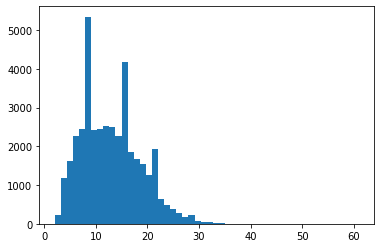

In [21]:
plt.hist(df_en['tweetLength'], 50)
plt.show

#### 20 joined tweets

In [12]:
len(df_es_20_long_text), len(df_en_20_long_text)

(2000, 2000)

In [24]:
df_es_20_long_text.head()

,author_id,lang,tweet_clean,type,tweetLength
0,f558a21dd8e02f2f7d4e5d5c3ea24195,es,muero de amor con milo 🥰 vieron cuando les da ...,0,224
1,f558a21dd8e02f2f7d4e5d5c3ea24195,es,que dolor de cabeza maldita birra buena noche ...,0,223
2,f558a21dd8e02f2f7d4e5d5c3ea24195,es,soy yo diciendo que tengo la gota jajsjssjjaja...,0,211
3,f558a21dd8e02f2f7d4e5d5c3ea24195,es,no se que hacer con mi vida we rt hastag foo q...,0,233
4,f558a21dd8e02f2f7d4e5d5c3ea24195,es,estuve diciendo duermo 15min mas desde las 8 d...,0,290


In [14]:
df_es_20_long_text['tweetLength'] = df_en_20_long_text['tweet_clean'].str.split().map(len)
print("---Es---")
print(df_es_20_long_text['tweetLength'].describe())

---Es---
count    2000.000000
mean      266.010500
std        40.318348
min       140.000000
25%       240.750000
50%       268.000000
75%       293.000000
max       413.000000
Name: tweetLength, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

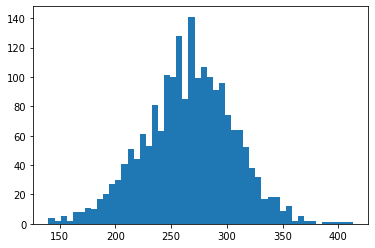

In [15]:
plt.hist(df_es_20_long_text['tweetLength'], 50)
plt.show

In [25]:
df_en_20_long_text.head()

,author_id,lang,tweet_clean,type
0,99cb2cd23f7cf613d394502d17dedad0,en,first catering 😎 hastag rt hastag vibes with s...,0
1,99cb2cd23f7cf613d394502d17dedad0,en,rt hastag wine tipsy gt alcohol tipsy rt hasta...,0
2,99cb2cd23f7cf613d394502d17dedad0,en,rt hastag hastag hastag all of a sudden its as...,0
3,99cb2cd23f7cf613d394502d17dedad0,en,rt hastag seen a 400 million contract at 033 r...,0
4,99cb2cd23f7cf613d394502d17dedad0,en,am i the only mf who smoke weed and is so sick...,0


In [26]:
df_en_20_long_text['tweetLength'] = df_en_20_long_text['tweet_clean'].str.split().map(len)
print("---En---")
print(df_en_20_long_text['tweetLength'].describe())

---En---
count    2000.000000
mean      258.480000
std        42.085011
min       128.000000
25%       229.000000
50%       259.000000
75%       286.000000
max       459.000000
Name: tweetLength, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

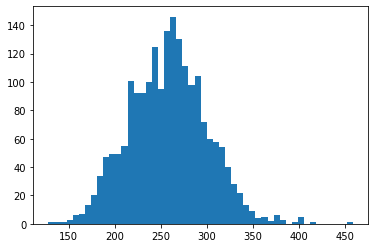

In [27]:
plt.hist(df_en_20_long_text['tweetLength'], 50)
plt.show

### Prepare data

#### Individual

In [7]:
# Spanish individual tweets

df_es = create_dataframe(esDirectory)
df_es['tweet_clean'] = df_es.tweet.apply(clean_text_es)

In [7]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_es)

df_es_test = create_dataframe(esTestDirectory)
df_es_test['tweet_clean'] = df_es_test.tweet.apply(clean_text_es)
x_test = df_es_test['tweet_clean'].values

es_cml = (x_train, y_train,
          x_valid, y_valid,
          x_test)

pickle_file = open('es_cml.pickle', 'wb')
pickle.dump(es_cml, pickle_file)
pickle_file.close()

In [33]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_es)

corpus_es = np.concatenate((x_train, x_valid), axis=None)
embedding_matrix = create_embedding_matrix(corpus_es, word_embedding_size=300)

df_es_test = create_dataframe(esTestDirectory)
df_es_test['tweet_clean'] = df_es_test.tweet.apply(clean_text_es)
x_test = df_es_test['tweet_clean'].values

train_padded, valid_padded, test_padded = to_int_seq(x_train, x_valid, x_test, max_length=15)

# GUARDAR AQUI
# embedding_matrix
# train_padded, y_train
# valid_padded, y_valid
# test_padded

es_indv = (embedding_matrix,
           train_padded, y_train,
           valid_padded, y_valid,
           test_padded)

pickle_file = open('es_indv.pickle', 'wb')
pickle.dump(es_indv, pickle_file)
pickle_file.close()

In [8]:
# English individual tweets

df_en = create_dataframe(enDirectory)
df_en['tweet_clean'] = df_en.tweet.apply(clean_text_en)

In [9]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_en)

df_es_test = create_dataframe(esTestDirectory)
df_es_test['tweet_clean'] = df_es_test.tweet.apply(clean_text_es)
x_test = df_es_test['tweet_clean'].values

en_cml = (x_train, y_train,
          x_valid, y_valid,
          x_test)

pickle_file = open('en_cml.pickle', 'wb')
pickle.dump(en_cml, pickle_file)
pickle_file.close()

In [34]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_en)

corpus_en = np.concatenate((x_train, x_valid), axis=None)
embedding_matrix = create_embedding_matrix(corpus_en, word_embedding_size=300)

df_en_test = create_dataframe(enTestDirectory)
df_en_test['tweet_clean'] = df_en_test.tweet.apply(clean_text_en)
x_test = df_en_test['tweet_clean'].values

train_padded, valid_padded, test_padded = to_int_seq(x_train, x_valid, x_test, max_length=15)

# GUARDAR AQUI
# embedding_matrix
# train_padded, y_train
# valid_padded, y_valid
# test_padded

en_indv = (embedding_matrix,
           train_padded, y_train,
           valid_padded, y_valid,
           test_padded)

pickle_file = open('en_indv.pickle', 'wb')
pickle.dump(en_indv, pickle_file)
pickle_file.close()

#### 20 joined tweets

In [9]:
# Spanish 20 joined tweets

df_es_20_long_text = join_tweets(df_es, 20)

In [ ]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_es_20_long_text)

df_es_20_long_text = join_tweets_test(df_es_test, 20)
x_test = df_es_20_long_text['tweet_clean'].values

train_padded, valid_padded, test_padded = to_int_seq(x_train, x_valid, x_test, max_length=250)

# GUARDAR AQUI
# embedding_matrix
# train_padded, y_train
# valid_padded, y_valid
# test_padded

es_20 = (#embedding_matrix,
           train_padded, y_train,
           valid_padded, y_valid,
           test_padded)

pickle_file = open('es_20.pickle', 'wb')
pickle.dump(es_20, pickle_file)
pickle_file.close()

In [23]:
# English 20 joined tweets

df_en_20_long_text = join_tweets(df_en, 20)

In [38]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_en_20_long_text)

df_en_20_long_text = join_tweets_test(df_en_test, 20)
x_test = df_en_20_long_text['tweet_clean'].values

train_padded, valid_padded, test_padded = to_int_seq(x_train, x_valid, x_test, max_length=250)

# GUARDAR AQUI
# embedding_matrix
# train_padded, y_train
# valid_padded, y_valid
# test_padded

en_20 = (#embedding_matrix,
           train_padded, y_train,
           valid_padded, y_valid,
           test_padded)

pickle_file = open('en_20.pickle', 'wb')
pickle.dump(en_20, pickle_file)
pickle_file.close()

#### Bert

In [13]:
# Spanish individual tweets

df_es = create_dataframe(esDirectory)
df_es['tweet_clean'] = df_es.tweet.apply(clean_text_es)

In [27]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_es)

df_es_test = create_dataframe(esTestDirectory)
df_es_test['tweet_clean'] = df_es_test.tweet.apply(clean_text_es)
x_test = df_es_test['tweet_clean'].values

In [34]:
train_padded, train_mask = prepare_data_bert(x_train, 15)
valid_padded, valid_mask = prepare_data_bert(x_valid, 15)
test_padded, test_mask = prepare_data_bert(x_test, 15)

es_indv_bert = (train_padded, train_mask, y_train,
                valid_padded, valid_mask, y_valid,
                test_padded, test_mask)

pickle_file = open('es_indv_bert.pickle', 'wb')
pickle.dump(es_indv_bert, pickle_file)
pickle_file.close()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [37]:
df_es_20_long_text = join_tweets(df_es, 20)
x_train, y_train, x_valid, y_valid = get_data_from_df(df_es_20_long_text)

df_es_20_long_text = join_tweets_test(df_es_test, 20)
x_test = df_es_20_long_text['tweet_clean'].values

In [38]:
train_padded, train_mask = prepare_data_bert(x_train, 250)
valid_padded, valid_mask = prepare_data_bert(x_valid, 250)
test_padded, test_mask = prepare_data_bert(x_test, 250)

es_20_bert = (train_padded, train_mask, y_train,
              valid_padded, valid_mask, y_valid,
              test_padded, test_mask)

pickle_file = open('es_20_bert.pickle', 'wb')
pickle.dump(es_20_bert, pickle_file)
pickle_file.close()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/david/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
Truncation was not explicitly activated but `max_length` is provided a specific value, pleas

#### Test predictions

In [23]:
# Spanish individual tweets

df_es = create_dataframe(esDirectory)
df_es['tweet_clean'] = df_es.tweet.apply(clean_text_es)

In [24]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_es)

df_es_test = create_dataframe(esTestDirectory)
df_es_test['tweet_clean'] = df_es_test.tweet.apply(clean_text_es)

test_id_es, x_test_es = df_es_test['author_id'].values, df_es_test['tweet_clean'].values

In [32]:
# Spanish 20 joined tweets

df_es_20_long_text = join_tweets(df_es, 20)

In [35]:
x_train, y_train, x_valid, y_valid = get_data_from_df(df_es_20_long_text)

df_es_20_long_text = join_tweets_test(df_es_test, 20)
x_test = df_es_20_long_text['tweet_clean'].values

# Get 1 every 20 ids or groupby?

_, _, test_padded = to_int_seq(x_train, x_valid, x_test, max_length=250)

In [44]:
test_id = []
for i in range(0, len(test_id_es), 200
    test_id.append(test_id_es[i])

In [48]:
test_es_20 = (test_id,
              test_padded)

pickle_file = open('test_es_20.pickle', 'wb')
pickle.dump(test_es_20, pickle_file)
pickle_file.close()

In [50]:
# English individual tweets

df_en = create_dataframe(enDirectory)
df_en['tweet_clean'] = df_en.tweet.apply(clean_text_en)

df_en_test = create_dataframe(enTestDirectory)
df_en_test['tweet_clean'] = df_en_test.tweet.apply(clean_text_en)

test_id_en, x_test_en = df_en_test['author_id'].values, df_en_test['tweet_clean'].values

# Spanish 20 joined tweets
df_en_20_long_text = join_tweets(df_en, 20)

x_train, y_train, x_valid, y_valid = get_data_from_df(df_en_20_long_text)

df_en_20_long_text = join_tweets_test(df_en_test, 20)
x_test = df_en_20_long_text['tweet_clean'].values

_, _, test_padded = to_int_seq(x_train, x_valid, x_test, max_length=250)

test_id = []
for i in range(0, len(test_id_en), 200):
    test_id.append(test_id_en[i])
    
test_en_20 = (test_id,
              test_padded)

pickle_file = open('test_en_20.pickle', 'wb')
pickle.dump(test_en_20, pickle_file)
pickle_file.close()

In [58]:
test_id_en[200]

'f8e9b6073d2fcbf9d2de3df07c62d86e'